# 1. Imports

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import gzip
from urllib import request


# Dataset Loader: load_mnist
filename = [
    ["training_images", "train-images-idx3-ubyte.gz"],
    ["test_images", "t10k-images-idx3-ubyte.gz"],
    ["training_labels", "train-labels-idx1-ubyte.gz"],
    ["test_labels", "t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "https://peterbloem.nl/files/mnist/"
    for name in filename:
        print("Downloading " + name[1] + "...")
        request.urlretrieve(base_url + name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28 * 28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist, f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl", 'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

def load_mnist(final=False, flatten=True):
    if not os.path.isfile('mnist.pkl'):
        init()
    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]
    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest = xtest.reshape(xsl, -1)
    if not final:
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10
    return (xtrain, ytrain), (xtest, ytest), 10


In [18]:
# data normalization
(xtrain, ytrain), (xval, yval), num_classes = load_mnist()
xtrain = xtrain / 255.0
xval = xval / 255.0


# 2. Forward and Backward Pass

In [21]:
def forwardpass(X, W, V, b_in, b_hidden):
    k = np.dot(X, W) + b_in
    h = 1 / (1 + np.exp(-k))  # Sigmoid activation
    o = np.dot(h, V) + b_hidden
    exp_values = np.exp(o - np.max(o, axis=1, keepdims=True))
    y_pred = exp_values / np.sum(exp_values, axis=1, keepdims=True)
    return y_pred, h

def backward_pass(y_pred, y_true, h, X, W, V):
    delta = y_pred - y_true
    v_prime = np.dot(h.T, delta) / X.shape[0]
    b_prime_hidden = np.sum(delta, axis=0, keepdims=True) / X.shape[0]
    h_prime = np.dot(delta, V.T) * h * (1 - h)
    w_prime = np.dot(X.T, h_prime) / X.shape[0]
    b_prime_input = np.sum(h_prime, axis=0, keepdims=True) / X.shape[0]
    return v_prime, w_prime, b_prime_hidden, b_prime_input


Epoch 1/5, Train Loss: 0.7764, Val Loss: 0.3661, Val Acc: 91.26%
Epoch 2/5, Train Loss: 0.4045, Val Loss: 0.2909, Val Acc: 92.24%
Epoch 3/5, Train Loss: 0.3511, Val Loss: 0.2624, Val Acc: 92.92%
Epoch 4/5, Train Loss: 0.3245, Val Loss: 0.2499, Val Acc: 93.08%
Epoch 5/5, Train Loss: 0.3070, Val Loss: 0.2363, Val Acc: 93.34%


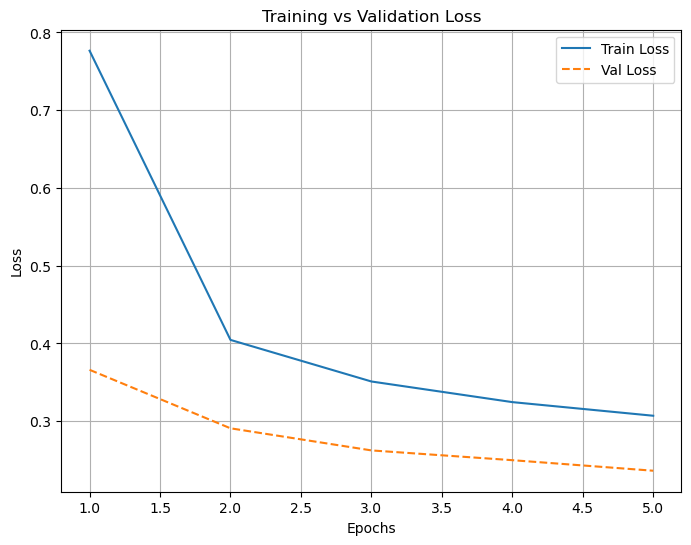

In [27]:
# Initialization
np.random.seed(0)
learning_rate = 0.03
epochs = 5
batch_size = 32

num_inputs = xtrain.shape[1]
num_hidden_units = 300
num_outputs = num_classes

W = np.random.normal(0, 0.1, (num_inputs, num_hidden_units))
V = np.random.normal(0, 0.1, (num_hidden_units, num_outputs))
b_in = np.zeros((1, num_hidden_units))
b_hidden = np.zeros((1, num_outputs))

train_losses = []
val_losses = []

# One-hot encode targets
ytrain_one_hot = np.eye(num_classes)[ytrain]
yval_one_hot = np.eye(num_classes)[yval]

for epoch in range(epochs):
    indices = np.random.permutation(xtrain.shape[0])
    xtrain_shuffled = xtrain[indices]
    ytrain_shuffled = ytrain_one_hot[indices]

    epoch_loss = 0
    for start in range(0, xtrain.shape[0], batch_size):
        end = start + batch_size
        X_batch = xtrain_shuffled[start:end]
        y_batch = ytrain_shuffled[start:end]

        y_pred, h = forwardpass(X_batch, W, V, b_in, b_hidden)
        batch_loss = -np.sum(y_batch * np.log(y_pred + 1e-8)) / batch_size
        epoch_loss += batch_loss

        v_prime, w_prime, b_prime_hidden, b_prime_input = backward_pass(y_pred, y_batch, h, X_batch, W, V)
        W -= learning_rate * w_prime
        V -= learning_rate * v_prime
        b_in -= learning_rate * b_prime_input
        b_hidden -= learning_rate * b_prime_hidden

    avg_loss = epoch_loss / (xtrain.shape[0] // batch_size)
    train_losses.append(avg_loss)

    y_val_pred, _ = forwardpass(xval, W, V, b_in, b_hidden)
    val_loss = -np.sum(yval_one_hot * np.log(y_val_pred + 1e-8)) / xval.shape[0]
    val_losses.append(val_loss)

    val_accuracy = np.mean(np.argmax(y_val_pred, axis=1) == yval)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy * 100:.2f}%")

# Plot losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Val Loss", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("vectorized_mlp_losses.png")
plt.show()
